In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from importlib import reload
from torch.utils.data import DataLoader,Dataset,RandomSampler,SequentialSampler
import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
import argparse
import random
import logging
logger = logging.getLogger(__name__)
from transformers import (AdamW, get_linear_schedule_with_warmup)
from torchkeras import summary
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
# Setup file handler
formatter = logging.Formatter('%(asctime)s - %(message)s')
           #logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler  = logging.FileHandler('my.log')
fhandler.setLevel(logging.DEBUG)
fhandler.setFormatter(formatter)
 
# Configure stream handler for the cells
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)
 
# Add both handlers
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.DEBUG)

数据处理
--

1 得到原始数据和离散，连续列

In [3]:
data_path='/media/xuweijia/DATA/代码/python_test/data/Criteo/demo_data/'
file_name='train.csv'

In [4]:
# get raw data
raw_df=pd.read_csv(os.path.join(data_path+file_name))
raw_df=raw_df.drop(["Id"],axis=1)
raw_df

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1,1.0,0,1.0,NaN,227.0,1.0,173.0,18.0,50.0,...,3486227d,e88ffc9d,c393dc22,b1252a9d,57c90cd9,NaN,bcdee96c,4d19a3eb,cb079c2d,456c12a0
1,1,4.0,1,1.0,2.0,27.0,2.0,4.0,2.0,2.0,...,07c540c4,92555263,NaN,NaN,242bb710,NaN,3a171ecb,72c78f11,NaN,NaN
2,1,0.0,806,NaN,NaN,1752.0,142.0,2.0,0.0,50.0,...,07c540c4,25c88e42,21ddcdc9,b1252a9d,a0136dd2,NaN,32c7478e,8fc66e78,001f3601,f37f3967
3,0,2.0,-1,42.0,14.0,302.0,38.0,25.0,38.0,90.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,c3abeb21,NaN,423fab69,1793a828,e8b83407,5cef228f
4,1,0.0,57,2.0,1.0,2891.0,2.0,35.0,1.0,137.0,...,e5ba7672,642f2610,1d1eb838,b1252a9d,1640d50b,ad3062eb,423fab69,45ab94c8,2bf691b1,c84c4aec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0,NaN,8,1.0,1.0,43.0,NaN,0.0,1.0,1.0,...,1e88c74f,fc35e8fe,NaN,NaN,a02708ad,c9d4222a,c3dc6cef,502f2493,NaN,NaN
1595,0,8.0,2,20.0,8.0,36.0,9.0,8.0,10.0,8.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,eea796be,NaN,3a171ecb,1793a828,e8b83407,5cef228f
1596,0,0.0,1,2.0,12.0,4877.0,140.0,13.0,34.0,136.0,...,e5ba7672,2b0a9d11,NaN,NaN,7453e535,NaN,dbb486d7,906e72ec,NaN,NaN
1597,0,NaN,2,NaN,1.0,1972.0,NaN,0.0,1.0,14.0,...,e5ba7672,817481a8,NaN,NaN,e4244d7f,c9d4222a,c7dc6720,60efe6e6,NaN,NaN


In [5]:
# 分别找出连续列/离散列
def col_type(df):
    dis_col=[]
    con_col=[]
    columns=df.columns.tolist()
    for c in columns:
        if df[c].dtype=='int64' or df[c].dtype=='float':
            con_col.append(c)
        else:
            dis_col.append(c)
    return dis_col,con_col
dis_col,con_col=col_type(raw_df)
con_col.remove("Label")
label="Label"

In [6]:
raw_df[con_col].values.dtype

dtype('float64')

In [7]:
# 默认是float64(double). 降低到float32. 与torch默认的兼容
raw_df[con_col]=raw_df[con_col].astype(np.float32)

In [8]:
raw_df[con_col].values.dtype

dtype('float32')

2 填充缺失值：数值型填0； 类别填空字符串，到时候也编码进去 （测试数据的缺失值用同样字符填充。相同编码）

In [9]:
null_token = '<NULL>'
raw_df[dis_col]=raw_df[dis_col].fillna(null_token)
raw_df[con_col]=raw_df[con_col].fillna(0)
raw_df

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1,1.0,0.0,1.0,0.0,227.0,1.0,173.0,18.0,50.0,...,3486227d,e88ffc9d,c393dc22,b1252a9d,57c90cd9,<NULL>,bcdee96c,4d19a3eb,cb079c2d,456c12a0
1,1,4.0,1.0,1.0,2.0,27.0,2.0,4.0,2.0,2.0,...,07c540c4,92555263,<NULL>,<NULL>,242bb710,<NULL>,3a171ecb,72c78f11,<NULL>,<NULL>
2,1,0.0,806.0,0.0,0.0,1752.0,142.0,2.0,0.0,50.0,...,07c540c4,25c88e42,21ddcdc9,b1252a9d,a0136dd2,<NULL>,32c7478e,8fc66e78,001f3601,f37f3967
3,0,2.0,-1.0,42.0,14.0,302.0,38.0,25.0,38.0,90.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,c3abeb21,<NULL>,423fab69,1793a828,e8b83407,5cef228f
4,1,0.0,57.0,2.0,1.0,2891.0,2.0,35.0,1.0,137.0,...,e5ba7672,642f2610,1d1eb838,b1252a9d,1640d50b,ad3062eb,423fab69,45ab94c8,2bf691b1,c84c4aec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0,0.0,8.0,1.0,1.0,43.0,0.0,0.0,1.0,1.0,...,1e88c74f,fc35e8fe,<NULL>,<NULL>,a02708ad,c9d4222a,c3dc6cef,502f2493,<NULL>,<NULL>
1595,0,8.0,2.0,20.0,8.0,36.0,9.0,8.0,10.0,8.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,eea796be,<NULL>,3a171ecb,1793a828,e8b83407,5cef228f
1596,0,0.0,1.0,2.0,12.0,4877.0,140.0,13.0,34.0,136.0,...,e5ba7672,2b0a9d11,<NULL>,<NULL>,7453e535,<NULL>,dbb486d7,906e72ec,<NULL>,<NULL>
1597,0,0.0,2.0,0.0,1.0,1972.0,0.0,0.0,1.0,14.0,...,e5ba7672,817481a8,<NULL>,<NULL>,e4244d7f,c9d4222a,c7dc6720,60efe6e6,<NULL>,<NULL>


3 可以做一些特征处理上的优化。比如数值型归一化。离散特征出现次数小于某阈值的，值都编码成\<UNK\>。这里忽略，假设已经做过了.也做过了特征选择

4 离散特征label-encode. 保存原始值到label的映射。之后根据映射后的id找对应embedding （取值10个以内的one-hot,作为新特征）
  如果想同一列加工出不同特征。可以用FeatureUnion和自定义transformer来选择列。 （如对文本列同时加工长度和tfidf两个特征）
  ColumnTransformer对同一列只能做一个操作。如果不对同一列做不同操作，就用这个就可以。

In [10]:
# %load FM_helper/LabelEncoder.py

In [11]:
# 直接当做包，引用py中函数
# labelencoding。
from FM_helper import LabelEncoder
reload(LabelEncoder)
trans,new_con_col,new_dis_col,df,raw_df2,cate_counts,cate_feature_map=LabelEncoder.labelencode_trans(raw_df,dis_col,con_col,label)
# 测试.只需要保存大transformer和最终的dis_col,con_col。 用来做转化，以及识别转换后的两类特征。 
LabelEncoder.test(raw_df,trans,new_con_col,new_dis_col,label)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,I5,I6,I7,I8,I9,I10,I11,I12,I13,Label
0,33.0,27.0,486.0,572.0,1.0,1.0,459.0,1.0,1.0,465.0,...,227.0,1.0,173.0,18.0,50.0,1.0,7.0,1.0,0.0,1.0
1,0.0,98.0,170.0,287.0,1.0,3.0,550.0,21.0,1.0,683.0,...,27.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,2.0,1.0
2,0.0,28.0,114.0,696.0,11.0,3.0,704.0,1.0,1.0,133.0,...,1752.0,142.0,2.0,0.0,50.0,0.0,1.0,0.0,0.0,1.0
3,0.0,12.0,650.0,243.0,1.0,3.0,329.0,1.0,1.0,27.0,...,302.0,38.0,25.0,38.0,90.0,1.0,3.0,0.0,38.0,0.0
4,0.0,36.0,517.0,70.0,1.0,3.0,20.0,2.0,1.0,166.0,...,2891.0,2.0,35.0,1.0,137.0,0.0,17.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0.0,93.0,617.0,801.0,1.0,1.0,25.0,12.0,1.0,28.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1595,30.0,12.0,1034.0,243.0,1.0,6.0,935.0,1.0,1.0,454.0,...,36.0,9.0,8.0,10.0,8.0,1.0,1.0,0.0,8.0,0.0
1596,30.0,113.0,676.0,7.0,1.0,6.0,185.0,14.0,1.0,485.0,...,4877.0,140.0,13.0,34.0,136.0,0.0,2.0,0.0,12.0,0.0
1597,0.0,48.0,565.0,727.0,1.0,6.0,377.0,0.0,1.0,202.0,...,1972.0,0.0,0.0,1.0,14.0,0.0,0.0,0.0,1.0,0.0


标准FM
--

公式：

$$y= b+ \sum_{i}w_ix_i  + \sum_{i}^{n}\sum_{j!=i}^{n}x_ix_j<\vec{v_i},\vec{v_j}>$$

一阶同LR. 每个连续特征对应一个$w_i$,每个离散特征one-hot之后的特征作为新特征，对应一个$w_i$

二阶交互，每个连续特征对应一个embedding。每个离散特征的每个每个特征的每个取值对应一个embedding

因此每个连续特征$x_i$,对应一个$w_i$,一个embedding，用来和其他特征交互。
   每个离散特征域，对应one-hot之后的C个特征$x_i$，对应C个$w_i$,C个embedding

但对每个样本来说，该离散特征one-hot之后，只会根据取值取到一个embedding，一个$w_i$<br/>(该离散特征对一阶的贡献，只有根据样本该离散特征取值映射到的$w_i$，对应取值$x_i$是1,其他C-1位置由于one-hot,该样本下取值$x_i$都是0,贡献是0)

因此总共需要维护（所有连续特征+所有离散特征的所有取值)个特征

假设所有连续特征和one-hot后的所有离散特征共F个,总共需要维护F个特征。可以根据特征名称，把每个特征映射到一个固定id上（位置）:<br/>
每个连续特征对应一个id                            <br/>
每个离散特征的每个取值对应一个id                    <br/>
每个id都维护一个$w_i$,一个embedding，对应该特征在W（F,1）,embedding(F,d)中的位置。<br/>
之后每个样本，都可以根据特征位置去找对应的$w_i$,embedding：       <br/>

因此在对每个样本进行映射时，需要分别得到样本每个特征的位置（id）和取值$x_i$：

位置映射：样本的所有特征都被映射到对应位置,用来找对应的$w_i$,embedding。每个连续特征对应的就是位置id。每个离散域，根据样本在该域的取值映射到对应id。n个离散域，对应n个embedding,n个$w_i$

样本取值：连续特征的取值不变（或者归一化），离散特征取值1，作为样本的$x_i$输入。n个离散域，对应的n个取值，$x_i$都是1。在one-hot后的对应位置上

### 对原始特征进行映射。得到one-hot之后的所有特征（含连续特征）到位置id的映射

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import os
class FeaturePosTrans(BaseEstimator, TransformerMixin):
    def __init__(self, dis_col=None, con_col= None, limit_freq = 0):
        self.dis_col=dis_col
        self.con_col=con_col
        self.limit_freq=limit_freq
        
        self.NULL = '<NULL>'
        self.UNK = '<UNK>'                                                # nlp里。低频是1，NAN是0. NAN作为padding,不参与训练且是0
                                                                          # NAN对应embedding： padding_index=0.只占位，不训练）
                                                                          # nn.Embedding(V,d,padding_idx=0
    
        self.dis_col_map=dict()                                            # 按特征，记录取值到位置id的映射  只用来存着
        self.feature_id_map=dict()                                         # 特征名到位置id的映射大表 {特征名_取值：位置id}
        self.pos=0                                                         # 位置id
        self.dis_col_count=dict()                                          # 每个离散特征的取值数目
        
        
        # 所有离散的缺失值，统一用NAN编码，之后在w，E中padding成0
        self.feature_id_map[self.NULL]=0
        self.pos+=1
        
        if (con_col!=None):
            self.feature_id_map.update(dict(zip(con_col,range(self.pos,self.pos+len(con_col))))) # 连续特征到对应位置的映射
            self.pos+=len(self.con_col)

    def fit(self, X , y = None):
        
        if (self.dis_col!=None):
            # 每个离散特征取值,映射到对应id
            for col in self.dis_col:
                valueCount=dict(X[col].value_counts())                       # 该离散特征。每个取值的出现数目
                # 是否特殊处理低频取值
                if self.limit_freq>0:
                    values=[k for k,v in valueCount.items() if k!=self.NULL and v>self.limit_freq]  # 该特征留下的取值
                    self.dis_col_map[col]=dict(zip(values,range(self.pos+1,self.pos+1+len(values))))
                    self.dis_col_map[col][self.UNK]=self.pos
                    # 组织大表。类似
                    new_values=[col+"_"+v for v in values]                    # { C1_v1：id}  
                    self.feature_id_map.update(dict(zip(new_values,range(self.pos+1,self.pos+1+len(new_values)))))
                    self.feature_id_map[col+"_"+self.UNK]=self.pos
                    self.pos+=len(new_values)+1                              # 每个特征留下：所有高频取值+UNK                                   
                else:
                    # 每个特征。分别记录映射
                    values=[k for k in valueCount.keys() if k!=self.NULL]    # 该离散特征所有取值（除缺失值） 
                    self.dis_col_map[col]=dict(zip(values,range(self.pos,self.pos+len(values))))
                    # 类似，但根据取值记在大map里
                    new_values=[col+"_"+v for v in values]                   # { C1_v1：id}  
                    self.feature_id_map.update(dict(zip(new_values,range(self.pos,self.pos+len(new_values)))))
                    self.pos+=len(new_values)
                    
                 # 每个离散特征的有效取值数目(不含NAN，含每个特征的unk)
                self.dis_col_count[col]=len(self.dis_col_map[col])                            
                                                                               
    def transform(self, X, label=None):        
        # 映射：
        feature_pos=X.copy()                        # 样本每个特征对应的位置
        feature_values=X.copy()                     # 样本每个特征的取值。离散特征取值是1.  
        cols=self.dis_col+self.con_col    
        
        # 如果有target列，删掉target列
        if label in feature_pos.columns:
            feature_pos=feature_pos.drop([label], axis=1)
            feature_values=feature_values.drop([label], axis=1)    # 特征列去掉label
        
        for col in cols:
            if col in self.dis_col:
                #values=X[col].apply(self.gen,args=(col,)).values
                values=X[col].apply(self.gen2,args=(col,)).values    # 组织形式不同。映射效果相同。用这个好些
                feature_pos[col]=values
                feature_values[col]=1.0
            else:
                feature_pos[col]=self.feature_id_map[col]            # 连续特征取值不变  。 位置是映射后的id 
        
        # 映射完的取值（包括离散特征取值1.0），也都变成float32
        feature_values=feature_values.astype(np.float32)
        
        return feature_pos,feature_values
        
    # 如果是多列。传入的x是该列对应的series. 输出的是这些列拼起来的df
    # 如果是单列，传入的x是该列的每个元素    输出的是该列对应的Series
    # 根据离散特征取值，返回对应的位置id
    def gen(self,x,col):
        if x==self.NULL:                                        # NAN统一映射到0
            return 0
        else:
            if x in self.dis_col_map[col]:
                return self.dis_col_map[col][x]                 # 按取值，映射到对应位置id
            else:
                if self.limit_freq>0:
                    return self.dis_col_map[col][self.UNK]       # 低频取值/没见过的值。映射到unqkey对应的编码 
                else:
                    return 0                                     # 没见过的值。映射到NAN==0。没有贡献

    # 用大表做映射。类似
    def gen2(self,x,col):    
        if x==self.NULL:                                         # NAN统一映射到0
            return 0
        else:
            x=col+"_"+x
            if x in self.feature_id_map:                         # 其他按取值，映射到对应位置id
                return self.feature_id_map[x]                 
            else:
                if self.limit_freq>0:                
                    return self.feature_id_map[col+"_"+self.UNK] # 低频取值/没见过的值。映射到该特征unqkey对应的编码 
                else:
                    return 0                                     # 没见过的值。映射到NAN。没有贡献
                
    def id2name(self):
        return dict(zip(self.feature_id_map.values(),self.feature_id_map.keys()))

In [13]:
raw_df.columns

Index(['Label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10',
       'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'],
      dtype='object')

In [14]:
#from FM_helper import Fmdata
#reload(Fmdata)
#f_trans=Fmdata.FeaturePosTrans(dis_col,con_col,10)
f_trans=FeaturePosTrans(dis_col,con_col,10)             # 出现10次以下的作为UNK
f_trans.fit(raw_df)
feature_pos,feature_values=f_trans.transform(raw_df,label)

In [15]:
len(f_trans.feature_id_map)  # 离散特征one-hot后，总的特征数目. NAN+con_col+all_dis

319

In [16]:
f_trans.feature_id_map

{'<NULL>': 0,
 'I1': 1,
 'I2': 2,
 'I3': 3,
 'I4': 4,
 'I5': 5,
 'I6': 6,
 'I7': 7,
 'I8': 8,
 'I9': 9,
 'I10': 10,
 'I11': 11,
 'I12': 12,
 'I13': 13,
 'C1_05db9164': 15,
 'C1_68fd1e64': 16,
 'C1_5a9ed9b0': 17,
 'C1_8cf07265': 18,
 'C1_be589b51': 19,
 'C1_5bfa8ab5': 20,
 'C1_f473b8dc': 21,
 'C1_87552397': 22,
 'C1_ae82ea21': 23,
 'C1_39af2607': 24,
 'C1_9a89b36c': 25,
 'C1_<UNK>': 14,
 'C2_38a947a1': 27,
 'C2_09e68b86': 28,
 'C2_80e26c9b': 29,
 'C2_d833535f': 30,
 'C2_4f25e98b': 31,
 'C2_287130e0': 32,
 'C2_0a519c5c': 33,
 'C2_08d6d899': 34,
 'C2_4c2bc594': 35,
 'C2_38d50e09': 36,
 'C2_207b2d81': 37,
 'C2_58e67aaf': 38,
 'C2_2c16a946': 39,
 'C2_942f9a8d': 40,
 'C2_8947f767': 41,
 'C2_421b43cd': 42,
 'C2_0468d672': 43,
 'C2_8084ee93': 44,
 'C2_78ccd99e': 45,
 'C2_1cfdf714': 46,
 'C2_68b3edbf': 47,
 'C2_e112a9de': 48,
 'C2_95e2d337': 49,
 'C2_e5fb1af3': 50,
 'C2_39dfaa0d': 51,
 'C2_e77e5e6e': 52,
 'C2_9819deea': 53,
 'C2_8cc9c66e': 54,
 'C2_f0cf0024': 55,
 'C2_3df44d94': 56,
 'C2_ae46a2

In [17]:
feature_pos

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1,2,3,4,5,6,7,8,9,10,...,213,240,249,257,258,0,279,284,305,309
1,1,2,3,4,5,6,7,8,9,10,...,212,219,0,0,258,0,276,284,0,0
2,1,2,3,4,5,6,7,8,9,10,...,212,219,250,257,258,0,275,284,299,309
3,1,2,3,4,5,6,7,8,9,10,...,210,220,250,257,258,0,277,287,298,309
4,1,2,3,4,5,6,7,8,9,10,...,210,219,249,257,258,270,277,290,301,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,1,2,3,4,5,6,7,8,9,10,...,215,219,0,0,258,271,274,284,0,0
1595,1,2,3,4,5,6,7,8,9,10,...,210,220,250,257,258,0,276,287,298,309
1596,1,2,3,4,5,6,7,8,9,10,...,210,219,0,0,258,0,282,284,0,0
1597,1,2,3,4,5,6,7,8,9,10,...,210,219,0,0,258,271,280,284,0,0


In [18]:
feature_values

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,1.0,0.0,1.0,0.0,227.0,1.0,173.0,18.0,50.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,4.0,1.0,1.0,2.0,27.0,2.0,4.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,806.0,0.0,0.0,1752.0,142.0,2.0,0.0,50.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2.0,-1.0,42.0,14.0,302.0,38.0,25.0,38.0,90.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,57.0,2.0,1.0,2891.0,2.0,35.0,1.0,137.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0.0,8.0,1.0,1.0,43.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1595,8.0,2.0,20.0,8.0,36.0,9.0,8.0,10.0,8.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1596,0.0,1.0,2.0,12.0,4877.0,140.0,13.0,34.0,136.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1597,0.0,2.0,0.0,1.0,1972.0,0.0,0.0,1.0,14.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
feature_values.values.dtype

dtype('float32')

In [20]:
allcols=dis_col+con_col
feature_values[allcols].values.dtype

dtype('float32')

### 建立自己的dataset和对应的dataloader

In [21]:
torch.set_default_dtype(torch.float32)           # torch模型参数的默认数据类型是flaot32.  np/pd是默认是flaot64(double).转成一样的

In [22]:
# 建dataset: 都放np,防止loader开多进程内存泄露:https://github.com/pytorch/pytorch/issues/13246#issuecomment-893198671）
class Mydata(Dataset):
    def __init__(self,fv,fp,target,mode='train'):
        super(Mydata, self).__init__()
        self.fv=fv           # np: m,n.  每个样本的特征取值 
        self.fp=fp           #           每个样本的特征位置.如果太大以后可以放np文件名.或切成多个文件,每次只打开一个(类似drml)
        self.target=target   #           如果mode==train/valid.对应y. mode==test。可以传入样本id。infer时不用
    def __len__(self):
        return len(self.fv)
    def __getitem__(self, index):
        return self.fp[index,:],self.fv[index],self.target[index]  # 提前做好了映射。当然映射也可以在这里做。

allcols=dis_col+con_col
trainDataset=Mydata(feature_values[allcols].values,feature_pos[allcols].values, raw_df[label].values)

In [23]:
train_sampler = RandomSampler(trainDataset)
train_dataloader = DataLoader(trainDataset, sampler=train_sampler, batch_size=32,num_workers=4)
epoch_num=3
for epoch in range(epoch_num):
    for batch_id,x in enumerate(train_dataloader):   # 把数据完整轮询一遍。对应一个epoch. 每一轮都是随机的
        # 输入模型
        break

In [24]:
x

[tensor([[16, 27, 59,  ..., 11, 12, 13],
         [16, 41, 59,  ..., 11, 12, 13],
         [16, 43, 59,  ..., 11, 12, 13],
         ...,
         [18, 36, 59,  ..., 11, 12, 13],
         [20, 28, 59,  ..., 11, 12, 13],
         [15, 35, 60,  ..., 11, 12, 13]]),
 tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  1.,  0.,  4.],
         ...,
         [ 1.,  1.,  1.,  ...,  7.,  0.,  4.],
         [ 1.,  1.,  1.,  ...,  2.,  0., 17.],
         [ 1.,  1.,  1.,  ...,  0.,  0.,  4.]]),
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
         0, 0, 0, 0, 0, 1, 0, 0])]

In [25]:
# DataLoader:   valid同
trainloader = DataLoader(trainDataset,        
                    shuffle=True,             # 每个epoch全部shuffle
                    batch_size=32,
                    collate_fn=None,          # 自定义如何拼batch。默认有，一般不需要。可以用来对batch padding（根据每个batch最长的text）
                                              # 传入的是一个batch，B个tuple. 每个tuple对应Dataset传出来的n个元素。
                                              # 自己重新拼成n个元素，每个元素B行，作为loader每次迭代的返回
                    pin_memory=False,         # 页锁定内存：不可分页，占用物理内存。 可分页内存：占用虚拟内存，用时候从磁盘读入物理内存
                                                # gpu需要通过页锁定内存中，把数据复制到gpu上
                                                #  数据从cpu的可分页内存内存传到gpu时，需要先把数据复制到临时的页锁定内存，再赋值到gpu.速度更慢
                                                #  如果指定pin_memory=True, batch的数据会直接被放在cpu的页锁定内存中，传到gpu时更快。少了一步复制
                                                #  但页锁定内存会占用真实物理内存，分配过多会挤占别的程序的内存，把内存耗尽。因此内存小时不建议用
                    sampler=None,             # 定义/自定义怎么从dataset里抽取每个batch的样本.还有一个batch_sampler参数
                                              # 需要实现__iter__方法。返回针对所有样本id的迭代器，顺序按自定义的样本顺序排好
                                              # 需要实现 __len__ ， 表示loader的一次抽取完成。一般同dataset样本数。
                                              # 就不能定义shuffle了，因为策略自己实现了。shuffle只能在iter里自己做。加入随机性
                                              # 每次loader会根据__iter__(和batch_size），迭代产生该epoch的每个batch。 
                                              # 比如nlp会根据样本文本长度，将长度相近样本排一起：iter([25,3,60,0,...1])。使得每个batch长度接近
                                              # 通过在__iter_里先切好batch,再shuffle,再整合。打乱每个epoch,batch间的执行顺序
                                              # 可以设置RandomSampler每次随机采样。（可参考该实现等）                       
                    num_workers=10            # 开多进程，每个进程计算一个batch。初始化时用之前提前处理好对应的n个batch。后续batch加入新的线程
                   )                          # 初始化时会一次性建好n个进程。每个进程提前处理好要用的batch数据。（底层是 multiprocessing）

In [26]:
epoch_num=3
for epoch in range(epoch_num):
    for batch_id,x in enumerate(trainloader):   # 把数据完整轮询一遍。对应一个epoch
        # 输入模型
        break

In [27]:
len(trainloader)                                # 每个epoch对应的batch的个数（step的数目）。一个epoch共50个batch

50

In [28]:
len(raw_df)//32

49

In [29]:
x

[tensor([[18, 29, 59,  ..., 11, 12, 13],
         [15, 26, 60,  ..., 11, 12, 13],
         [24, 26,  0,  ..., 11, 12, 13],
         ...,
         [15, 33, 61,  ..., 11, 12, 13],
         [15, 29, 59,  ..., 11, 12, 13],
         [15, 26, 62,  ..., 11, 12, 13]]),
 tensor([[ 1.,  1.,  1.,  ...,  0.,  0.,  2.],
         [ 1.,  1.,  1.,  ...,  2.,  0., 10.],
         [ 1.,  1.,  1.,  ...,  1.,  0.,  0.],
         ...,
         [ 1.,  1.,  1.,  ...,  0.,  0.,  4.],
         [ 1.,  1.,  1.,  ..., 15.,  1., 82.],
         [ 1.,  1.,  1.,  ...,  2.,  0.,  0.]]),
 tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0])]

In [30]:
f_p,f_v,y=x[0],x[1],x[2]

### 原始FM模型

模型维持n个w,n个embedding，对应one-hot后的所有特征（这里还算上了缺失值对应的0参数）

二阶分数是$$\sum_{i}^{n}\sum_{j!=i}^{n}x_ix_j<\vec{v_i},\vec{v_j}>$$

直接计算是$O(n^2*k)$。每对向量内积是$k$,共$O(n^2)$个pair。最后求和

等价于embedding们对应位置22相乘后，再求和。可以先求所有embedding每个维度元素22相乘的和，最后再对所有维度求和

$$\sum_{i}^{n}\sum_{j!=i}^{n}<\vec{e_i},\vec{e_j}>= \sum_{f} \sum_{i}^{n}\sum_{j!=i}^{n}e_{if}*e_{jf} $$

embedding的每个维度元素22相乘的和： $ab+ac+bc= \frac{1}{2}((a+b+c)^2-(a^2+b^2+c^2))$

因此对固定维度，embedding的每个维度元素22相乘的和$\sum_{i}^{n}\sum_{j!=i}^{n}e_{if}*e_{jf}$ ，是$\frac{1}{2}((e_{if}+e_{jf}...)^2-(e_{if}^2+e_{if}^2+...))$

可以通过每个embedding相加（对应位置相加）的平方，减去每个embedding平方的相加，得到（1，k）的向量，作为embedding的每个维度元素22交互的结果。最终的二阶分数是这k个维度的结果相加。

也可以把这k维向量作为新的隐特征，输入后续网络。作为FM/deepFM的一个小变体

转化后，$\frac{1}{2}((e_{if}+e_{jf}...)^2-(e_{if}^2+e_{if}^2+...))$的复杂度只有$O(n)$(n个元素相加或平方后相加)。加上维度F，总的复杂度可以降低到$O(nk)$

In [31]:
class FM(nn.Module):
    def __init__(self,n_field,n_features,embed_size,dropout=0,init_w=False):
        """
        标准FM
        n_field: 原始离散特征数目
        n_features: 离散特征one-hot之后,和dense的总特征个数. 这里包含了一个缺失值特征向量，paddding成0
        """
        super(FM, self).__init__()
        self.n_field=n_field             # 原始特征数目
        self.n_features=n_features       # 连续+离散特征的总数目 (离散特征one-hot+unique化后的。且算上最终的一个padding)
        self.k=embed_size
        
        self.W=nn.Embedding(n_features,1,padding_idx=0)                       # 每个特征对应的wi。位置0是0对梯度无贡献。embedding默认是N(0,1)
        self.w0=nn.Parameter(torch.zeros([1,]))                               # b初始化为0
        self.feature_embed=nn.Embedding(n_features,embed_size,padding_idx=0)  # 每个特征对应的embedding
        self.droplayer=nn.Dropout(dropout)
        
        self.scoreweight=nn.Parameter(0.5*torch.ones([2,]))                   # 一阶，二阶score的权重 
                                                                              
        if init_w:
            self.__init_weight__()                                                # 初始化权重(可以不调用，用默认的)
            
    def __init_weight__(self):              # 初始化权重.默认是N(0,1)
        inn=n_features-1
        # kaiming_normal_
        nn.init.kaiming_uniform_(self.feature_embed.weight[1:], mode='fan_in', nonlinearity='relu')  # sqrt(6/inn)
        nn.init.normal_(self.W.weight[1:],0, np.sqrt(2.0 /inn))
        
    def forward(self,f_p,f_x): # B,n.  n是每个样本的原始特征数目
        """
        f_p: (B,N)  每个样本的原始特征，根据特征名（连续特征）/特征取值（离散特征）被映射到embedding上的位置。 N:原始特征数目
        f_x: (B,N)  每个样本的原始特征，对应的取值。 离散特征对应的是one-hot后的，所以在对应的f_p上取值为1
        """
        batch_size=f_p.shape[0]
        
        # 一阶score
        w=self.W(f_p.long()).reshape(batch_size,-1)              # B,n   每个样本根据原始特征，找到对应位置处的w
        y_score1=self.w0 + torch.sum(torch.mul(w,f_x),1)  # B,1   wixi+b  B,n -->   B,1.  要是不sum，也可以作为n个特征。之后作为deepFM的改造
        
        # 二阶score
        embed=self.feature_embed(f_p.long())             # B,n,d 每个样本根据原始特征，找到对应位置处的embedding
        
        embed=torch.mul(embed,f_x.unsqueeze(2))           # B,n,d 样本的每个向量乘上对应的xi： xi* embedding
                                                          #       tf.mul:按位置乘.广播 (B,n,d) * (B,n,1) ->(B,n,d) 
                                                          #       离散特征对应的xi是1.假设数值型已经归一化
        
        embed=self.droplayer(embed)
        
        # 每个filed 向量22交互
        e_sum= torch.sum(embed,1)                         # B,d   每个样本。所有embedding对应维度元素相加，得到e_sum
        e_sum_square=torch.square(e_sum)                  # B,d   (e_sum)^2
        
        e_square=torch.square(embed)                      # B,n,d  平方后的
        e_square_sum=torch.sum(e_square,1)                # B,d    每个维度相加
        
        f =0.5*(e_sum_square-e_square_sum)                # B,d    n个embedding，每个维度元素22交互的结果（可作为新特征，拼接到后边）
    
        y_score2= torch.sum(f,1)                          # (B,)
        
        logits=y_score1+y_score2                          # (B,)   最终分数  y_score1*self.scoreweight[0] +..
        
        # TODO:loss加正则项（最后加）/ grad-clip等. 看下train-loop
        
        return logits

### 原始deepFM模型

FM部分相同，但共享底层的embedding部分。把样本原始离散特征和连续特征映射得到的所有embedding，concat,作为后续mlp的输入。输出结果作为deep部分的score,和linear(FM)部分相加

In [32]:
# deepFM： 标准的。 或者上述k个元素作为特征统一拼到deep的
class deepFM(nn.Module):
    def __init__(self,n_field,n_features,embed_size,hiddens,dropout=0,batchnorm=True,init_w=False):
        """
        标准DeepFM
        n_field: 原始特征数目
        n_features: 离散特征one-hot之后,和dense的总特征个数. 这里包含了一个缺失值特征向量，paddding成0
        deep每层：linear + (bn) + relu + (dropout).  输出hidden层。  最后按需单独linear到1
        """
        super(deepFM, self).__init__() 
        self.n_field=n_field             # 原始特征数目
        self.n_features=n_features       # 连续+离散特征的总数目 (离散特征one-hot+unique化后的。且算上最终的一个padding)
        self.k=embed_size
        self.dropout=dropout
        self.batchnorm=batchnorm
        self.hiddens=hiddens             # hiddens:[256,64,32]
    
        # FM-part
        self.W=nn.Embedding(n_features,1,padding_idx=0)                       # 每个特征对应的wi。位置0是0对梯度无贡献。embedding默认是N(0,1)
        self.w0=nn.Parameter(torch.zeros([1,]))                               # b初始化为0
        self.feature_embed=nn.Embedding(n_features,embed_size,padding_idx=0)  # 每个特征对应的embedding
        self.droplayer=nn.Dropout(dropout)            
 
        # deep-part.
        input_size=n_field*embed_size                                         #输入是所有原始特征的embedding拼接   
        self.mlp=self.build_mlp(input_size,hiddens)                           #多层mlp.输出hidden  是一个ModuleList
        self.finallinear=nn.Linear(hiddens[-1],1,bias=True)                   #最后一层linear
        
        if init_w:
            self.__init_deep_weight__()                                       # 初始化权重。(可以按情况调用。现在用kaiming)
            self.__init_wide_weight__()
            
    def __init_wide_weight__(self):              # 初始化权重.默认是N(0,1)
        inn=n_features-1
        # kaiming_normal_
        nn.init.kaiming_uniform_(self.feature_embed.weight[1:], mode='fan_in', nonlinearity='relu')  # sqrt(6/inn)
        nn.init.normal_(self.W.weight[1:],0, np.sqrt(2.0 /inn))

    def __init_deep_weight__(self):              # 初始化权重
        for layer in self.mlp:
            if (layer.__class__.__name__=='Linear'):  # 每层初始化
                self.init_linear(layer)
        self.init_linear(self.finallinear)
        
    def init_linear(self,layer):
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')  #sqrt(2/inn) 或者 sqrt(2/out)
        nn.init.constant_(layer.bias, 0)

    def build_mlp(self,input_size,hiddens):
        """
        hiddens:[256,56,32]
        输出最后一层的hidden节点 （dropout+激活后的），可直接linear+sigmoid到deepscore. 也可以拼其他特征后再linear
        """        
        layers=nn.ModuleList()
        
        hiddens.insert(0,input_size)     #  [inputsize,256,56,32]
        num_layer=len(hiddens)-1         #  3层
        
        for i in range(0,len(hiddens)-1):
            
            # 线性层
            in_dim=hiddens[i]
            out_dim=hiddens[i+1]
            print(in_dim,out_dim)
            layer=nn.Linear(in_dim,out_dim,bias=True)
            layers.append(layer)
            
            # BN
            if self.batchnorm:
                layers.append(nn.BatchNorm1d(out_dim)) 
            
            # active + dropout
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout))
                
        return layers  # 拼成一个前后连接的网络。可以在forward里作为一个模块被整体调用
    
    
    def forward(self,f_p,f_x): # B,n.  n是每个样本的原始特征数目
        """
        f_p: (B,N)  每个样本的原始特征，根据特征名（连续特征）/特征取值（离散特征）被映射到embedding上的位置。 N:原始特征数目
        f_x: (B,N)  每个样本的原始特征，对应的取值。 离散特征对应的是one-hot后的，所以在对应的f_p上取值为1
        output:  FM和deep部分 score相加
        """
        batch_size=f_p.shape[0]
        
        # FM-part    每个filed 向量22交互
        w=self.W(f_p.long()).reshape(batch_size,-1)       # B,n   每个样本根据原始特征，找到对应位置处的w
        y_score1=self.w0 + torch.sum(torch.mul(w,f_x),1)  # B,1   wixi+b  B,n -->   B,1.  要是不sum，也可以作为n个特征。
        
        embed=self.feature_embed(f_p.long())              # B,n,d 每个样本根据原始特征，找到对应位置处的embedding 
        embed=torch.mul(embed,f_x.unsqueeze(2))           # B,n,d 样本的每个向量乘上对应的xi： xi* embedding
        e_sum= torch.sum(embed,1)                         # B,d   每个样本。所有embedding对应维度元素相加，得到e_sum
        e_sum_square=torch.square(e_sum)                  # B,d   (e_sum)^2
        e_square=torch.square(embed)                      # B,n,d  平方后的
        e_square_sum=torch.sum(e_square,1)                # B,d    每个维度相加
        f =0.5*(e_sum_square-e_square_sum)                # B,d    n个embedding，每个维度元素22交互的结果（可作为新特征，拼接到后边）
        y_score2= torch.sum(f,1)                          # (B,)
        
        # deep-part
        x=torch.reshape(embed,[-1,self.n_field*self.k])           # 输入是所有原始特征对应embedding的拼接
        for layer in self.mlp:
            if(layer.__class__.__name__=='Linear'):
                pass
                #print(x.mean(),x.std())        # 可以画一下数据分布
            x=layer(x)
        
        y_deep=self.finallinear(x).squeeze(-1)         # (B，)
        
        logits=y_score1+y_score2 +y_deep
        
        return logits

In [33]:
n_field=len(dis_col+con_col)           # 原始特征数目
n_features=len(f_trans.feature_id_map) # 连续+离散特征的总数目 (离散特征one-hot+unique化后的。且算上最终的一个padding)
embed_size=8

In [34]:
# 初始化模型
hiddens=[256,56,32]
model=deepFM(n_field,n_features,embed_size,hiddens,dropout=0.5)
#model=FM(n_field,n_features,embed_size)

312 256
256 56
56 32


In [35]:
model

deepFM(
  (W): Embedding(319, 1, padding_idx=0)
  (feature_embed): Embedding(319, 8, padding_idx=0)
  (droplayer): Dropout(p=0.5, inplace=False)
  (mlp): ModuleList(
    (0): Linear(in_features=312, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=56, bias=True)
    (5): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=56, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
  )
  (finallinear): Linear(in_features=32, out_features=1, bias=True)
)

In [36]:
# 模拟一次forward
logits=model(f_p,f_v)
target=y
loss_func= nn.BCEWithLogitsLoss()    #  mean [yn⋅logσ(xn)+(1−yn)⋅log(1−σ(xn))]
loss=loss_func(logits,target.float())

In [37]:
target

tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0])

In [38]:
logits

tensor([-4.6649e+02,  9.4968e+07,  2.6344e+07, -4.5242e+04,  1.0596e+08,
         9.4102e+06, -1.8754e+06,  1.5729e+05,  1.4914e+07, -4.1156e+02,
        -2.5024e+04,  7.8015e+04,  3.7353e+05,  2.9482e+05,  2.9137e+06,
         4.6145e+06, -1.5992e+03,  1.6609e+04, -5.6583e+02,  2.6153e+06,
         2.6686e+05,  3.0936e+06,  1.1477e+06,  9.3876e+06,  1.0052e+07,
         1.3624e+05,  2.0149e+05,  1.0667e+05, -2.2243e+02,  4.6544e+06,
         2.7154e+06,  1.2359e+06], grad_fn=<AddBackward0>)

In [39]:
loss

tensor(5882399., grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [40]:
loss.item()

5882399.0

In [41]:
type(loss.item())

float

In [42]:
F.binary_cross_entropy_with_logits(logits, target.float())  # 用函数结果相同

tensor(5882399., grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [43]:
model.feature_embed.weight

Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5379e-02,  8.3295e-01,  8.4104e-01,  ..., -1.1325e+00,
         -1.1526e-01, -1.0548e+00],
        [ 7.9266e-01, -1.9427e-01, -2.2217e-01,  ..., -8.0690e-01,
         -6.3068e-01,  6.7988e-01],
        ...,
        [-2.1309e-01,  7.3917e-01, -1.0914e+00,  ..., -1.3881e+00,
         -1.5116e+00,  2.3293e-01],
        [ 1.5651e-03,  8.7171e-01,  5.9178e-01,  ..., -4.9002e-02,
         -1.6792e+00, -5.9992e-02],
        [-8.2036e-01, -1.6829e+00,  8.5449e-01,  ...,  6.2719e-01,
         -7.3890e-01, -1.2190e+00]], requires_grad=True)

### train_loop

正常trainloop + reg + grad_clip  + CV

In [44]:
ss=StandardScaler()
ss.fit(raw_df[con_col])                           #归一化
raw_df[con_col]=ss.transform(raw_df[con_col])     # 测试做相同处理

f_trans=FeaturePosTrans(dis_col,con_col,0)           # 映射到对应id. 出现10次以下的作为UNK
f_trans.fit(raw_df)
feature_pos,feature_values=f_trans.transform(raw_df,label)  # 测试集做相同处理。用相同的原始con_col,dis_col。 label只是用来删除掉该列
cols=dis_col+con_col

处理过的数据，划分cv。 训练5个模型，用5个模型的平均作为最终结果（同时也保存这5个模型。作为衡量该模型最终表现的量度）
也可以有放回的每次随机采样一份：df.sample(frac=0.7,random_state =i)

In [45]:
skf=StratifiedKFold(n_splits=5,random_state=2020,shuffle=True)    # 分割器。按y值对给定的样本划分。返回分好的样本id 每轮4:1

In [46]:
for i,(train_index,dev_index) in enumerate(skf.split(raw_df,raw_df[label])): # 可用于df. 根据y，输出分割后的train/dev样本位置
    logger.info("训练第%s折对应的模型",i)                                    # 每个fold训一个模型
    
    train_fv=feature_values[cols].iloc[train_index].values                # 按样本位置，从转换好的df里取训练样本
    train_fp=feature_pos[cols].iloc[train_index].values
    train_label=raw_df[label].iloc[train_index].values
    trainDataset=Mydata(train_fv,train_fp, train_label)                   # 对应的dataset
    
    dev_fv=feature_values[cols].iloc[dev_index].values                    # dev场景下，主要是计算指标。model不输出loss
    dev_fp=feature_pos[cols].iloc[dev_index].values
    dev_label=raw_df[label].iloc[dev_index].values                        # test用raw_df[label]
    dev_dataset=Mydata(dev_fv,dev_fp, dev_label)                          
    
    #train(train_dataset,dev_dataset)
    break

2022-03-13 19:18:14,187 - 训练第0折对应的模型


建立一个class,用来封装基本模型。预测，保存，重新加载等

In [159]:
#设置随机种子。每次训练固定  
def set_seed(args):
    random.seed(args.random_seed)
    np.random.seed(args.random_seed)
    torch.manual_seed(args.random_seed)
    
# 用来算平均的
class AverageMeter(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class WrapModel(object):
    def __init__(self,args=None,state_dict=None):
        # 初始化模型
        n_field=len(args.dis_col+args.con_col)                # 原始特征数目
        n_features=len(args.f_trans.feature_id_map)           # 连续+离散特征one-hot后的特征总数目 (算上一个NAN padding)
        #model=FM(n_field,n_features,args.embed_size,args.dropout,args.init_w)
        model=deepFM(n_field,n_features,args.embed_size,args.hiddens,args.dropout,args.batchnorm,args.init_w)
        
        if state_dict:                                        # 加载保存过的模型参数（如果有）
            model.load_state_dict(state_dict)
       
        device = torch.device("cuda:0" if args.cuda else "cpu") # 放gpu上 （相比.cuda(),优先使用这个。方便在不同设备上切换）
        model.to(device) 
        
        self.model=model
        args.device=device
        self.args=args
        set_seed(args)

        
    def train(self,train_dataset,dev_dataset=None):        # 参考jupyter的loss画图
        args=self.args
        model=self.model
        
        # 设置train-loader. 每次都是随机取（无放回）
        sampler = RandomSampler(train_dataset)
        train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=args.batch_size,num_workers=4) 
        
        # 设置优化器
        parameters = [p for p in self.model.parameters() if p.requires_grad]  # 可只优化模型的部分层/部分parameter
        if args.optimizer == 'sgd':
            optimizer = optim.SGD(parameters, lr=args.lr,momentum=0.9,weight_decay=0.08)
        elif args.optimizer == 'adamax':
            optimizer = optim.Adamax(parameters,weight_decay=0.08)
        elif args.optimizer == 'adamaW':
            optimizer = AdamW(parameters, lr=args.lr, eps=1e-8,weight_decay=0.08)
        elif args.optimizer == 'adam':
            optimizer = optim.Adam(parameters, lr=0.001)  # demo里的
        
        
        # 定义lr本身的scheduler. 
        # 在多个epoch过程中，调节优化器中lr本身的大小。每个step通过schcduler.step()改变lr本身的值。optimizer里的lr被同步修改。
        # 但只改变lr的值。其他算法仍同optimizer
        # 在限定step内，让lr从0线性增加到设定值。防止初始lr较大，模型不稳定。之后认为模型稳定.再线性减小，到最终训练完lr减小到0
        num_training_steps=int(len(train_loader)*args.epochs)      # 完整训练过程中总的steps:每个step对应一个batch.
        num_warmup_steps=int(num_training_steps*0.2)               # 预热期steps的数目：占总step的20%。在这些step内，让lr从0线性增加到设定值。此时认为模型稳定了
        if args.schedule_lr:
            scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps,num_training_steps) # 先预热一些step.再逐渐减小。
            logger.info("最初的lr:{}".format(scheduler.get_lr()))  # lr此时是0  增到设定lr后，最终训练完仍减小到0
                                                                                                                              
        # train-loop
        logger.info("***** Running training *****")
        logger.info("  总的样本数量 = %d", len(train_dataset))
        logger.info("  epoch数目 = %d", args.epochs) 
        logger.info("  train batch size = %d",args.batch_size)
        logger.info("  所有epoch总的steps = %d", num_training_steps) 
        
        global_step = 0                      # 记录总的step
        best_metric=0.0

        model.zero_grad()                    # 把模型所有参数的梯度都置为0 （optimizer.zero_grad是把优化器里参数的梯度置为0）
        
        steps=[]
        losses=[]                           # 所有epoch.每个loss
        avg_losses=[]                       # 该epoch.截止目前step的所有loss的平均
        nstep_avg_losses=[]                 # 该epoch.每n个step,loss的平均
        
        eval_losses=[]
        eval_metrics=[]
        eval_steps=[]
        
        for epoch in enumerate(range(args.epochs)):                 # 每个epoch
            
            loss_sum=0.0                                            # 用来记录每个epoch到此时的平均loss,平均metric
            metric_sum = 0.0
            nstep_avg_loss = AverageMeter()                         # epoch内，每n个step loss的平均。 n==display_steps
          
            for step, batch in enumerate(train_loader):  # dataset按batch-size轮询一遍。每个batch一个step
                
                # 输入放到对应设备上。同模型
                f_p,f_v,y= (x.to(args.device) for x in batch)   # trian、dev时才用y. test时没有y,dataset传入id列或任意列。但不用
                del batch
                
                model.train()  # train mode
                
                logits=model(f_p,f_v)                                  # 输出logits,before sigmoid: (B,1)
                
                loss=self.compute_loss(logits,y)                       # 计算该batch的loss (TODO:可以添加L2)
                
                optimizer.zero_grad()                                  # 清空之前的参数梯度
                loss.backward()                                        # 根据loss重新计算模型参数梯度
                #print(batch_loss.item())
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)   # 对算好的梯度 grad_clip
                
                optimizer.step()                                      # 根据梯度更新参数
                if args.schedule_lr:
                    scheduler.step()                                  # 更新lr值
                global_step += 1
                
                # 评估train   平均loss.metric
                loss_sum+=loss.item()                                 # 该epoch截止到目前所有step内的平均。 item():转为float
                nstep_avg_loss.update(loss.item(),f_p.shape[0])       # 每n个step内的平均
                try:
                    metric_sum+=self.eval_metric(y.detach().numpy(),torch.sigmoid(logits).detach().numpy())# 单纯是这些样本对应的面积。不是真正的auc
                except ValueError:
                    pass
                
                if (step+1) % args.display_steps==0:
                    print('Epoch = {}|step = {}/{}|loss = {:.2f}|auc={:.2f}'.format(epoch,step+1,len(train_loader),
                                                                                    loss_sum/(step+1),
                                                                                    metric_sum/(step+1)))
                    avg_losses.append(loss_sum/(step+1))  #每个epoch内的平均loss
                    losses.append(loss.item())            #每个step的单个loss
                    nstep_avg_losses.append(nstep_avg_loss.avg) # epoch内.每n个step的单个loss。n==display_steps
                    nstep_avg_loss.reset()
                    steps.append(global_step)
                    
                # 评估eval集上的表现。打印。好的话保存
                if (step+1) % args.eval_steps==0 and (dev_dataset is not None):
                        
                    dev_probs,dev_loss = self.infer(dev_dataset)         # 计算所有样本的概率. 以及平均loss
                    dev_metric = self.eval_metric(dev_dataset.target,dev_probs)  # 根据输出计算整体metric

                    print('Epoch = {}|step = {}/{}|dev_loss = {:.2f}|dev_auc={:.2f}'.format(epoch,step+1,
                                                                                            len(train_loader),
                                                                                            dev_loss,
                                                                                            dev_metric))
                    if dev_metric > best_metric:
                        best_metric=dev_metric
                        logger.info("  "+"*"*20)  
                        logger.info("  Best dev auc:%s",round(best_metric,4))
                        logger.info("  "+"*"*20)                          
                        # 保存dev上最好的模型
                        self.save("best_model.pt")
                          
                    eval_losses.append(dev_loss)
                    eval_metrics.append(dev_metric)
                    eval_steps.append(global_step)
              
                
            #每个epoch结束,也eval+保存
            if dev_dataset is not None:
                dev_probs,dev_loss = self.infer(dev_dataset)         # 计算所有样本的概率. 以及平均loss
                dev_metric = self.eval_metric(dev_dataset.target,dev_probs)  # 根据输出计算整体metric
                print('Epoch = {}|dev_loss = {:.2f}|dev_auc={:.2f}'.format(epoch,dev_loss,dev_metric))
                if dev_metric > best_metric:
                    best_metric=dev_metric
                    logger.info("  "+"*"*20)  
                    logger.info("  Best dev auc:%s",round(best_metric,4))
                    logger.info("  "+"*"*20)                          
                    # 保存dev上最好的模型
                    self.save("best_model.pt")

                eval_losses.append(dev_loss)
                eval_metrics.append(dev_metric)
                eval_steps.append(global_step)
            print(" Final best dev auc:%s",round(best_metric,4))
 
        self.steps=steps
        self.losses=losses
        self.avg_losses=avg_losses
        self.nstep_avg_losses=nstep_avg_losses
                          
        self.eval_metrics=eval_metrics
        self.eval_losses=eval_losses
        self.eval_steps=eval_steps
                          
    def compute_loss(self,logits,labels,reduction='mean'):
        '''
        计算一个batch的loss
        logits:(B,1) before sigmoid
        labels:(B,1) 每个样本的取值0/1
        '''
        loss=F.binary_cross_entropy_with_logits(logits,labels.float(),reduction=reduction) #  mean [yn⋅logσ(xn)+(1−yn)⋅log(1−σ(xn))]
        return loss

    
    def eval_metric(self,labels,probs):
        '''
        根据label和预测值，计算这些样本对应的metric
        preds: （m,）/ (m,C)   预测类别。二分类是1的概率P(1) 。多分类是该类每个取值的概率（每行相加为1），每类映射顺序同labels的字典/数字序
        labels:（m,）          真实类别 二分类取值0/1 多分类取值[0，C-1]
        '''
        # auc:
        auc=roc_auc_score(labels, probs)               # pred:对应sklearn里的prob,已转化为1的概率（二分类）/多类概率（多分类）
        # 2分类acc
        binary_acc= len(labels[labels==(probs>0.5)])/len(labels)
        # 多分类acc
        acc= np.mean(labels== np.argmax(probs,-1))
        
        return auc
    
    @torch.no_grad()                                            # 等于with torch.no_grad()。 不构建计算图
    def infer(self,test_dataset,mode='eval'):
        '''
        单纯计算所有样本的输出
        output: 每个样本取值是1的概率  （或者多分类的概率）。之后可以直接用来算metric
        loss:所有样本的平均loss
        '''
        args=self.args
        model=self.model        
        eval_sampler = SequentialSampler(test_dataset)           # 按dataset的顺序
        eval_dataloader = DataLoader(test_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size,num_workers=4)
        
        model.eval()                                             # eval模式
        
        preds=[]
        losses=[]
        for step, batch in enumerate(eval_dataloader):           # 轮询eval dataset

            # 输入放到对应设备上。同模型
            f_p,f_v,y = (x.to(args.device) for x in batch)   # trian、dev时才用y. test时没有y,dataset传入id列或任意列。但不用
            del batch

            
            logits=model(f_p,f_v)                                   # 输出logits,before sigmoid: (B,1)
            preds.append(F.sigmoid(logits).cpu().numpy())           # 每个batch的概率             (B,1)
            
            if mode=='eval':
                losses.append(self.compute_loss(logits,y,reduction='sum')) # 所有样本的loss相加
            
        live_probs=np.concatenate(preds,0)
        loss= np.sum(losses)/len(test_dataset)                           # 最后取平均
            
        return live_probs,loss
    
    
    def save(self,filename):
        '保存超参数和内部模型的模型参数'
        params = {
            'state_dict': self.model.state_dict(),   # 只按参数名称保存模型所有参数。是一个dict.不保存模型结构
            'args': self.args,
        }
        torch.save(params, filename)           # 保存static等到指定文件中。 这里可以保存字典，之后通过load加载进来（底层pickle）
    
    
    @staticmethod
    def load(filename):   
        '直接根据文件名，返回加载好内部模型参数的WraPModel（init时通过state_dict）.可以在外边直接调用：WrapModel.load(f)'
        saved_params = torch.load(
            filename, map_location=lambda storage, loc: storage  # load默认直接加载到GPU.  这样指定，先加载到cpu上。再load_state
        )
        state_dict = saved_params['state_dict']
        args = saved_params['args']
        
        return WrapModel(args,state_dict)     
    
    def export_onnx(self,onnx_filename):
        '需要用到nn.Module等'
        pass

In [160]:
parser = argparse.ArgumentParser()                             # 超参数
parser.add_argument('--embed_size', type=int, default=8)
parser.add_argument('--dropout', type=float, default=0,help='默认没有dropout')
parser.add_argument('--batchnorm', type=bool, default=False,help='默认没有batchnorm')
parser.add_argument('--epochs', type=int, default=20)
parser.add_argument('--max_grad_norm', type=float, default=1.0)  #1
parser.add_argument('--optimizer', type=str, default='adamaW')
parser.add_argument('--lr', type=float, default=0.001,help='优化器步长') # 8e-5
parser.add_argument('--schedule_lr', type=bool, default=False,help='是否优化lr,先warm再降低')
parser.add_argument('--init_w', type=bool, default=False,help='是否用xvaier/kaiming等随机初始化')
parser.add_argument('--hiddens', type=str, default='256,56,32',help='deepfm的mlp层数')
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--display_steps', type=int, default=10,help='打印日志的step间隔')
parser.add_argument('--eval_steps', type=int, default=10)
parser.add_argument('--eval_batch_size', type=int, default=4096)
parser.add_argument('--no-cuda', type=bool, default=False,help='是否用GPU')
parser.add_argument('--gpu', type=int, default=0,help='GPU设备id')
parser.add_argument('--random_seed', type=int, default=2020)
args = parser.parse_args(args=[])                              # jupyter里需要加args=[]
args.dis_col=dis_col
args.con_col=con_col
args.label='Label'
args.f_trans=f_trans
args.hiddens=[int(h) for h in args.hiddens.split(',')]
# 设置设备为某固定gpu
args.cuda = (not args.no_cuda)  and  (torch.cuda.is_available())
if args.cuda:
    torch.cuda.set_device(args.gpu)

In [161]:
CTRmodel=WrapModel(args)

312 256
256 56
56 32


In [162]:
CTRmodel.model

deepFM(
  (W): Embedding(10995, 1, padding_idx=0)
  (feature_embed): Embedding(10995, 8, padding_idx=0)
  (droplayer): Dropout(p=0, inplace=False)
  (mlp): ModuleList(
    (0): Linear(in_features=312, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=56, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=56, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
  )
  (finallinear): Linear(in_features=32, out_features=1, bias=True)
)

In [163]:
summary(CTRmodel.model,input_shape=[(39,),(39,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                [-1, 39, 1]          10,995
         Embedding-2                [-1, 39, 8]          87,960
            Linear-3                  [-1, 256]          80,128
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 56]          14,392
              ReLU-7                   [-1, 56]               0
           Dropout-8                   [-1, 56]               0
            Linear-9                   [-1, 32]           1,824
             ReLU-10                   [-1, 32]               0
          Dropout-11                   [-1, 32]               0
           Linear-12                    [-1, 1]              33
Total params: 195,332
Trainable params: 195,332
Non-trainable params: 0
-------------------------------

In [164]:
#CTRmodel.train(trainDataset)
CTRmodel.train(trainDataset,dev_dataset)

2022-03-13 20:01:39,421 - ***** Running training *****
2022-03-13 20:01:39,421 -   总的样本数量 = 1279
2022-03-13 20:01:39,422 -   epoch数目 = 20
2022-03-13 20:01:39,422 -   train batch size = 32
2022-03-13 20:01:39,422 -   所有epoch总的steps = 800


Epoch = (0, 0)|step = 10/40|loss = 18.84|auc=0.44


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:39,715 -   ********************
2022-03-13 20:01:39,716 -   Best dev auc:0.5544
2022-03-13 20:01:39,717 -   ********************


Epoch = (0, 0)|step = 10/40|dev_loss = 19.06|dev_auc=0.55
Epoch = (0, 0)|step = 20/40|loss = 19.39|auc=0.49


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:39,930 -   ********************
2022-03-13 20:01:39,930 -   Best dev auc:0.5571
2022-03-13 20:01:39,931 -   ********************


Epoch = (0, 0)|step = 20/40|dev_loss = 18.75|dev_auc=0.56
Epoch = (0, 0)|step = 30/40|loss = 18.63|auc=0.52


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:40,161 -   ********************
2022-03-13 20:01:40,162 -   Best dev auc:0.5584
2022-03-13 20:01:40,162 -   ********************


Epoch = (0, 0)|step = 30/40|dev_loss = 18.40|dev_auc=0.56
Epoch = (0, 0)|step = 40/40|loss = 18.64|auc=0.52


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:40,368 -   ********************
2022-03-13 20:01:40,369 -   Best dev auc:0.5625
2022-03-13 20:01:40,369 -   ********************


Epoch = (0, 0)|step = 40/40|dev_loss = 17.75|dev_auc=0.56
Epoch = (0, 0)|dev_loss = 17.75|dev_auc=0.56
 Final best dev auc:%s 0.5625


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (1, 1)|step = 10/40|loss = 14.44|auc=0.61


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:40,843 -   ********************
2022-03-13 20:01:40,844 -   Best dev auc:0.5694
2022-03-13 20:01:40,845 -   ********************


Epoch = (1, 1)|step = 10/40|dev_loss = 16.98|dev_auc=0.57
Epoch = (1, 1)|step = 20/40|loss = 15.29|auc=0.58


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:41,077 -   ********************
2022-03-13 20:01:41,078 -   Best dev auc:0.5749
2022-03-13 20:01:41,078 -   ********************


Epoch = (1, 1)|step = 20/40|dev_loss = 16.66|dev_auc=0.57
Epoch = (1, 1)|step = 30/40|loss = 14.72|auc=0.58


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:41,298 -   ********************
2022-03-13 20:01:41,299 -   Best dev auc:0.5799
2022-03-13 20:01:41,299 -   ********************


Epoch = (1, 1)|step = 30/40|dev_loss = 16.45|dev_auc=0.58
Epoch = (1, 1)|step = 40/40|loss = 14.85|auc=0.58


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:41,521 -   ********************
2022-03-13 20:01:41,521 -   Best dev auc:0.5836
2022-03-13 20:01:41,522 -   ********************


Epoch = (1, 1)|step = 40/40|dev_loss = 16.36|dev_auc=0.58
Epoch = (1, 1)|dev_loss = 16.36|dev_auc=0.58
 Final best dev auc:%s 0.5836


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (2, 2)|step = 10/40|loss = 16.81|auc=0.59


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:42,029 -   ********************
2022-03-13 20:01:42,030 -   Best dev auc:0.589
2022-03-13 20:01:42,030 -   ********************


Epoch = (2, 2)|step = 10/40|dev_loss = 16.08|dev_auc=0.59
Epoch = (2, 2)|step = 20/40|loss = 13.74|auc=0.58


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:42,263 -   ********************
2022-03-13 20:01:42,264 -   Best dev auc:0.5932
2022-03-13 20:01:42,264 -   ********************


Epoch = (2, 2)|step = 20/40|dev_loss = 15.93|dev_auc=0.59
Epoch = (2, 2)|step = 30/40|loss = 12.76|auc=0.59


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:42,482 -   ********************
2022-03-13 20:01:42,482 -   Best dev auc:0.5974
2022-03-13 20:01:42,483 -   ********************


Epoch = (2, 2)|step = 30/40|dev_loss = 15.80|dev_auc=0.60
Epoch = (2, 2)|step = 40/40|loss = 12.58|auc=0.60


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:42,691 -   ********************
2022-03-13 20:01:42,692 -   Best dev auc:0.6014
2022-03-13 20:01:42,693 -   ********************


Epoch = (2, 2)|step = 40/40|dev_loss = 15.64|dev_auc=0.60


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (2, 2)|dev_loss = 15.64|dev_auc=0.60
 Final best dev auc:%s 0.6014
Epoch = (3, 3)|step = 10/40|loss = 11.34|auc=0.67


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:43,189 -   ********************
2022-03-13 20:01:43,190 -   Best dev auc:0.6043
2022-03-13 20:01:43,190 -   ********************


Epoch = (3, 3)|step = 10/40|dev_loss = 15.50|dev_auc=0.60
Epoch = (3, 3)|step = 20/40|loss = 10.80|auc=0.66


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:43,409 -   ********************
2022-03-13 20:01:43,409 -   Best dev auc:0.6079
2022-03-13 20:01:43,410 -   ********************


Epoch = (3, 3)|step = 20/40|dev_loss = 15.44|dev_auc=0.61
Epoch = (3, 3)|step = 30/40|loss = 10.69|auc=0.66


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:43,624 -   ********************
2022-03-13 20:01:43,624 -   Best dev auc:0.6099
2022-03-13 20:01:43,625 -   ********************


Epoch = (3, 3)|step = 30/40|dev_loss = 15.35|dev_auc=0.61
Epoch = (3, 3)|step = 40/40|loss = 10.50|auc=0.66


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (3, 3)|step = 40/40|dev_loss = 15.18|dev_auc=0.61
Epoch = (3, 3)|dev_loss = 15.18|dev_auc=0.61
 Final best dev auc:%s 0.6099


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (4, 4)|step = 10/40|loss = 10.26|auc=0.64


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:44,210 -   ********************
2022-03-13 20:01:44,210 -   Best dev auc:0.614
2022-03-13 20:01:44,211 -   ********************


Epoch = (4, 4)|step = 10/40|dev_loss = 15.28|dev_auc=0.61
Epoch = (4, 4)|step = 20/40|loss = 9.73|auc=0.66


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:44,409 -   ********************


Epoch = (4, 4)|step = 20/40|dev_loss = 14.99|dev_auc=0.62


2022-03-13 20:01:44,410 -   Best dev auc:0.6178
2022-03-13 20:01:44,411 -   ********************


Epoch = (4, 4)|step = 30/40|loss = 8.89|auc=0.70


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:44,627 -   ********************
2022-03-13 20:01:44,627 -   Best dev auc:0.6183
2022-03-13 20:01:44,628 -   ********************


Epoch = (4, 4)|step = 30/40|dev_loss = 14.81|dev_auc=0.62
Epoch = (4, 4)|step = 40/40|loss = 8.78|auc=0.69


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (4, 4)|step = 40/40|dev_loss = 15.09|dev_auc=0.62
Epoch = (4, 4)|dev_loss = 15.09|dev_auc=0.62
 Final best dev auc:%s 0.6183


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (5, 5)|step = 10/40|loss = 7.25|auc=0.73


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:45,362 -   ********************
2022-03-13 20:01:45,363 -   Best dev auc:0.619
2022-03-13 20:01:45,364 -   ********************


Epoch = (5, 5)|step = 10/40|dev_loss = 15.07|dev_auc=0.62
Epoch = (5, 5)|step = 20/40|loss = 6.57|auc=0.73


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:45,587 -   ********************
2022-03-13 20:01:45,588 -   Best dev auc:0.6247
2022-03-13 20:01:45,589 -   ********************


Epoch = (5, 5)|step = 20/40|dev_loss = 14.98|dev_auc=0.62
Epoch = (5, 5)|step = 30/40|loss = 6.58|auc=0.74


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:45,791 -   ********************
2022-03-13 20:01:45,792 -   Best dev auc:0.6329
2022-03-13 20:01:45,792 -   ********************


Epoch = (5, 5)|step = 30/40|dev_loss = 14.82|dev_auc=0.63
Epoch = (5, 5)|step = 40/40|loss = 7.16|auc=0.73


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (5, 5)|step = 40/40|dev_loss = 15.19|dev_auc=0.63
Epoch = (5, 5)|dev_loss = 15.19|dev_auc=0.63
 Final best dev auc:%s 0.6329


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (6, 6)|step = 10/40|loss = 5.44|auc=0.80
Epoch = (6, 6)|step = 10/40|dev_loss = 15.07|dev_auc=0.62
Epoch = (6, 6)|step = 20/40|loss = 5.34|auc=0.78


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (6, 6)|step = 20/40|dev_loss = 14.64|dev_auc=0.62
Epoch = (6, 6)|step = 30/40|loss = 5.98|auc=0.78


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (6, 6)|step = 30/40|dev_loss = 15.14|dev_auc=0.62
Epoch = (6, 6)|step = 40/40|loss = 5.57|auc=0.80


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (6, 6)|step = 40/40|dev_loss = 15.16|dev_auc=0.62
Epoch = (6, 6)|dev_loss = 15.16|dev_auc=0.62
 Final best dev auc:%s 0.6329


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (7, 7)|step = 10/40|loss = 3.66|auc=0.75


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:47,434 -   ********************
2022-03-13 20:01:47,435 -   Best dev auc:0.6337
2022-03-13 20:01:47,436 -   ********************


Epoch = (7, 7)|step = 10/40|dev_loss = 15.02|dev_auc=0.63
Epoch = (7, 7)|step = 20/40|loss = 4.24|auc=0.79


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (7, 7)|step = 20/40|dev_loss = 15.89|dev_auc=0.62
Epoch = (7, 7)|step = 30/40|loss = 4.13|auc=0.80


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (7, 7)|step = 30/40|dev_loss = 15.28|dev_auc=0.63
Epoch = (7, 7)|step = 40/40|loss = 4.20|auc=0.81


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (7, 7)|step = 40/40|dev_loss = 15.03|dev_auc=0.63


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (7, 7)|dev_loss = 15.03|dev_auc=0.63
 Final best dev auc:%s 0.6337
Epoch = (8, 8)|step = 10/40|loss = 2.23|auc=0.90
Epoch = (8, 8)|step = 10/40|dev_loss = 15.39|dev_auc=0.63
Epoch = (8, 8)|step = 20/40|loss = 2.94|auc=0.88


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:48,654 -   ********************
2022-03-13 20:01:48,655 -   Best dev auc:0.6346
2022-03-13 20:01:48,656 -   ********************


Epoch = (8, 8)|step = 20/40|dev_loss = 15.30|dev_auc=0.63
Epoch = (8, 8)|step = 30/40|loss = 3.04|auc=0.88
Epoch = (8, 8)|step = 30/40|dev_loss = 16.05|dev_auc=0.62


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (8, 8)|step = 40/40|loss = 3.01|auc=0.88


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (8, 8)|step = 40/40|dev_loss = 15.83|dev_auc=0.62


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (8, 8)|dev_loss = 15.83|dev_auc=0.62
 Final best dev auc:%s 0.6346
Epoch = (9, 9)|step = 10/40|loss = 2.20|auc=0.91
Epoch = (9, 9)|step = 10/40|dev_loss = 16.24|dev_auc=0.63
Epoch = (9, 9)|step = 20/40|loss = 1.94|auc=0.93


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (9, 9)|step = 20/40|dev_loss = 16.05|dev_auc=0.63
Epoch = (9, 9)|step = 30/40|loss = 1.90|auc=0.92


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (9, 9)|step = 30/40|dev_loss = 16.13|dev_auc=0.62
Epoch = (9, 9)|step = 40/40|loss = 1.92|auc=0.92


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (9, 9)|step = 40/40|dev_loss = 16.36|dev_auc=0.60
Epoch = (9, 9)|dev_loss = 16.36|dev_auc=0.60
 Final best dev auc:%s 0.6346


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (10, 10)|step = 10/40|loss = 1.66|auc=0.94
Epoch = (10, 10)|step = 10/40|dev_loss = 15.65|dev_auc=0.62
Epoch = (10, 10)|step = 20/40|loss = 1.56|auc=0.94


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (10, 10)|step = 20/40|dev_loss = 15.48|dev_auc=0.61
Epoch = (10, 10)|step = 30/40|loss = 1.34|auc=0.95
Epoch = (10, 10)|step = 30/40|dev_loss = 16.20|dev_auc=0.60
Epoch = (10, 10)|step = 40/40|loss = 1.42|auc=0.95


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (10, 10)|step = 40/40|dev_loss = 15.41|dev_auc=0.62


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (10, 10)|dev_loss = 15.41|dev_auc=0.62
 Final best dev auc:%s 0.6346
Epoch = (11, 11)|step = 10/40|loss = 0.64|auc=0.97
Epoch = (11, 11)|step = 10/40|dev_loss = 15.52|dev_auc=0.62
Epoch = (11, 11)|step = 20/40|loss = 0.59|auc=0.97


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (11, 11)|step = 20/40|dev_loss = 15.29|dev_auc=0.63
Epoch = (11, 11)|step = 30/40|loss = 0.54|auc=0.98


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2022-03-13 20:01:51,866 -   ********************
2022-03-13 20:01:51,867 -   Best dev auc:0.6392
2022-03-13 20:01:51,867 -   ********************


Epoch = (11, 11)|step = 30/40|dev_loss = 15.25|dev_auc=0.64
Epoch = (11, 11)|step = 40/40|loss = 0.77|auc=0.97


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (11, 11)|step = 40/40|dev_loss = 15.91|dev_auc=0.63


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (11, 11)|dev_loss = 15.91|dev_auc=0.63
 Final best dev auc:%s 0.6392
Epoch = (12, 12)|step = 10/40|loss = 0.72|auc=0.97
Epoch = (12, 12)|step = 10/40|dev_loss = 15.60|dev_auc=0.62
Epoch = (12, 12)|step = 20/40|loss = 0.52|auc=0.98


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (12, 12)|step = 20/40|dev_loss = 16.27|dev_auc=0.61
Epoch = (12, 12)|step = 30/40|loss = 0.43|auc=0.99


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (12, 12)|step = 30/40|dev_loss = 16.17|dev_auc=0.61
Epoch = (12, 12)|step = 40/40|loss = 0.45|auc=0.99


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (12, 12)|step = 40/40|dev_loss = 15.81|dev_auc=0.63


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (12, 12)|dev_loss = 15.81|dev_auc=0.63
 Final best dev auc:%s 0.6392
Epoch = (13, 13)|step = 10/40|loss = 0.16|auc=1.00
Epoch = (13, 13)|step = 10/40|dev_loss = 15.82|dev_auc=0.63
Epoch = (13, 13)|step = 20/40|loss = 0.17|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (13, 13)|step = 20/40|dev_loss = 15.97|dev_auc=0.63
Epoch = (13, 13)|step = 30/40|loss = 0.17|auc=1.00
Epoch = (13, 13)|step = 30/40|dev_loss = 16.02|dev_auc=0.61
Epoch = (13, 13)|step = 40/40|loss = 0.25|auc=0.99


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (13, 13)|step = 40/40|dev_loss = 15.69|dev_auc=0.62
Epoch = (13, 13)|dev_loss = 15.69|dev_auc=0.62
 Final best dev auc:%s 0.6392


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (14, 14)|step = 10/40|loss = 0.11|auc=0.99
Epoch = (14, 14)|step = 10/40|dev_loss = 15.59|dev_auc=0.61
Epoch = (14, 14)|step = 20/40|loss = 0.07|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (14, 14)|step = 20/40|dev_loss = 15.70|dev_auc=0.62
Epoch = (14, 14)|step = 30/40|loss = 0.08|auc=1.00
Epoch = (14, 14)|step = 30/40|dev_loss = 16.35|dev_auc=0.60
Epoch = (14, 14)|step = 40/40|loss = 0.13|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (14, 14)|step = 40/40|dev_loss = 15.99|dev_auc=0.61
Epoch = (14, 14)|dev_loss = 15.99|dev_auc=0.61
 Final best dev auc:%s 0.6392


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (15, 15)|step = 10/40|loss = 0.15|auc=1.00
Epoch = (15, 15)|step = 10/40|dev_loss = 15.93|dev_auc=0.61
Epoch = (15, 15)|step = 20/40|loss = 0.14|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (15, 15)|step = 20/40|dev_loss = 15.84|dev_auc=0.61
Epoch = (15, 15)|step = 30/40|loss = 0.13|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (15, 15)|step = 30/40|dev_loss = 15.39|dev_auc=0.62
Epoch = (15, 15)|step = 40/40|loss = 0.13|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (15, 15)|step = 40/40|dev_loss = 15.74|dev_auc=0.63


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (15, 15)|dev_loss = 15.74|dev_auc=0.63
 Final best dev auc:%s 0.6392
Epoch = (16, 16)|step = 10/40|loss = 0.06|auc=1.00
Epoch = (16, 16)|step = 10/40|dev_loss = 15.90|dev_auc=0.62
Epoch = (16, 16)|step = 20/40|loss = 0.18|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (16, 16)|step = 20/40|dev_loss = 15.83|dev_auc=0.61
Epoch = (16, 16)|step = 30/40|loss = 0.14|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (16, 16)|step = 30/40|dev_loss = 16.12|dev_auc=0.61
Epoch = (16, 16)|step = 40/40|loss = 0.13|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (16, 16)|step = 40/40|dev_loss = 15.72|dev_auc=0.61


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (16, 16)|dev_loss = 15.72|dev_auc=0.61
 Final best dev auc:%s 0.6392
Epoch = (17, 17)|step = 10/40|loss = 0.05|auc=1.00
Epoch = (17, 17)|step = 10/40|dev_loss = 15.79|dev_auc=0.61
Epoch = (17, 17)|step = 20/40|loss = 0.06|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (17, 17)|step = 20/40|dev_loss = 16.19|dev_auc=0.61
Epoch = (17, 17)|step = 30/40|loss = 0.06|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (17, 17)|step = 30/40|dev_loss = 16.04|dev_auc=0.62
Epoch = (17, 17)|step = 40/40|loss = 0.07|auc=1.00
Epoch = (17, 17)|step = 40/40|dev_loss = 15.97|dev_auc=0.62


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (17, 17)|dev_loss = 15.97|dev_auc=0.62
 Final best dev auc:%s 0.6392


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (18, 18)|step = 10/40|loss = 0.04|auc=1.00
Epoch = (18, 18)|step = 10/40|dev_loss = 15.95|dev_auc=0.62
Epoch = (18, 18)|step = 20/40|loss = 0.02|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (18, 18)|step = 20/40|dev_loss = 15.91|dev_auc=0.61
Epoch = (18, 18)|step = 30/40|loss = 0.03|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (18, 18)|step = 30/40|dev_loss = 15.88|dev_auc=0.62
Epoch = (18, 18)|step = 40/40|loss = 0.06|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (18, 18)|step = 40/40|dev_loss = 15.66|dev_auc=0.62
Epoch = (18, 18)|dev_loss = 15.66|dev_auc=0.62
 Final best dev auc:%s 0.6392


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (19, 19)|step = 10/40|loss = 0.01|auc=1.00
Epoch = (19, 19)|step = 10/40|dev_loss = 15.48|dev_auc=0.63
Epoch = (19, 19)|step = 20/40|loss = 0.02|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (19, 19)|step = 20/40|dev_loss = 15.34|dev_auc=0.63
Epoch = (19, 19)|step = 30/40|loss = 0.03|auc=1.00


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (19, 19)|step = 30/40|dev_loss = 15.46|dev_auc=0.62
Epoch = (19, 19)|step = 40/40|loss = 0.03|auc=1.00
Epoch = (19, 19)|step = 40/40|dev_loss = 15.96|dev_auc=0.60


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = (19, 19)|dev_loss = 15.96|dev_auc=0.60
 Final best dev auc:%s 0.6392


/home/xuweijia/.conda/envs/pytorch1.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


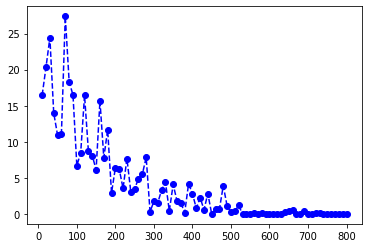

In [165]:
plt.plot(CTRmodel.steps, CTRmodel.losses, 'bo--')  # 每个step的单个loss

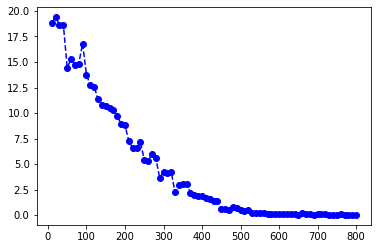

In [166]:
plt.plot(CTRmodel.steps, CTRmodel.avg_losses, 'bo--') # 每个step,对应的epoch截止到该step时的平均loss

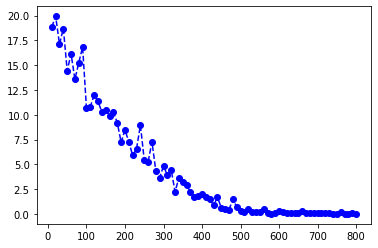

In [167]:
plt.plot(CTRmodel.steps, CTRmodel.nstep_avg_losses, 'bo--') # 每个step,对应的epoch截止到该step时的平均loss

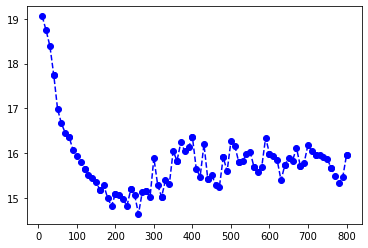

In [168]:
plt.plot(CTRmodel.eval_steps, CTRmodel.eval_losses, 'bo--')  # deepFM 300差不多了 最好0.6左右 但FM一直欠拟合 最好0.5417

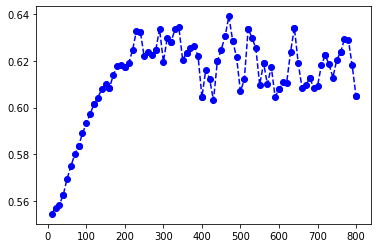

In [169]:
plt.plot(CTRmodel.eval_steps, CTRmodel.eval_metrics, 'bo--') # 300左右

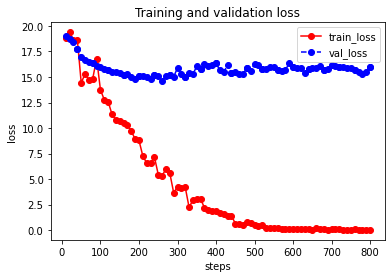

In [170]:
metric='loss'
plt.plot(CTRmodel.steps, CTRmodel.avg_losses, 'ro-')
plt.plot(CTRmodel.eval_steps, CTRmodel.eval_losses, 'bo--')
plt.title('Training and validation '+ 'loss')
plt.xlabel("steps")
plt.ylabel('loss')
plt.legend(["train_"+metric, 'val_'+metric])
plt.show()                                                             # 100左右就过有点拟合了